## Task and objectives

### Task 

This task is about training a neural network on 30 house satellite images with 25 of them associated to label images indicating the roofs. 

### Goal

The goal is to train a neural network model on 25 images and show predictions on the remaining 5 images.

### Method

The task at hand can be identified as an image segmentation problem. Therefore a U-net architecture (see [here](https://link.springer.com/content/pdf/10.1007/978-3-319-24574-4_28.pdf) for more info on the U_net model) was used in order to train the model. The motivation to this choice of architecture is that it was designed to give good results when only a small number of training images are available. Moreover, is computationally fast.
Below are the steps taken to solve the given problem.

In [1]:
!pip install opencv-python           ### installing opencv for image visualization


### Important libraries

In [21]:
# Dealing with directories(folders)

import os
import glob

# Scientific computing and dealing with arrays
import numpy as np
import random

# Data visualization
from matplotlib import pyplot as plt
import cv2

# Data preprocessing
from sklearn.model_selection import train_test_split

# Dealing with convolutional neural network
from keras.models import Model
from tensorflow.keras.utils import normalize
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import warnings
warnings.filterwarnings("ignore")

### Importing and splitting data into train and test sets

In [3]:
# The next three functions are to map the satellites house images to their corresponding labels

# read file names from a dir into a list
def ReadDir(dir):
    filelist = []    
    for filename in glob.glob(os.path.join(dir, '*.png')):
        filelist.append(filename)       
    return filelist


In [4]:
ReadDir("Satellites/satellites")

['Satellites/satellites/337.png',
 'Satellites/satellites/317.png',
 'Satellites/satellites/301.png',
 'Satellites/satellites/343.png',
 'Satellites/satellites/417.png',
 'Satellites/satellites/121.png',
 'Satellites/satellites/539.png',
 'Satellites/satellites/320.png',
 'Satellites/satellites/314.png',
 'Satellites/satellites/241.png',
 'Satellites/satellites/284.png',
 'Satellites/satellites/537.png',
 'Satellites/satellites/379.png',
 'Satellites/satellites/278.png',
 'Satellites/satellites/287.png',
 'Satellites/satellites/272.png',
 'Satellites/satellites/328.png',
 'Satellites/satellites/303.png',
 'Satellites/satellites/274.png',
 'Satellites/satellites/551.png',
 'Satellites/satellites/308.png',
 'Satellites/satellites/324.png',
 'Satellites/satellites/535.png',
 'Satellites/satellites/270.png',
 'Satellites/satellites/315.png',
 'Satellites/satellites/300.png',
 'Satellites/satellites/381.png',
 'Satellites/satellites/345.png',
 'Satellites/satellites/553.png',
 'Satellites/s

In [5]:
# Get the file names
def GetFileName(filedir):
    return filedir[-7:]

In [6]:
# Compare files in two directories dir1 and dir2 with the same file name, to see if they are identical

def CmpDir(dir1, dir2):
    
    list_1 =[]
    list_2 =[]

    [list1, list2] = map(ReadDir, [dir1, dir2])
    list1.sort()
    list2.sort()
    l1 = len(list1)
    l2 = len(list2)
    if l1 < l2:
        for filedir2 in list2:
            filename = GetFileName(filedir2)
            filedir1 = dir1 + filename
            if filedir1 in list1:
                list_1.append(filedir2)
            else:
                list_2.append(filedir2)
    else:
        pass
    return[list_1, list_2]



#### Splitting 

In [7]:
# Here we perform the train test set splitting
X_train_dir, X_test_dir = CmpDir("Labels/labels/", "Satellites/satellites/")
#len(X_test_dir)

In [8]:
def train_test_set(Dir1, Dir2):
    Sat = []
    for directory_path in glob.glob(Dir1):
        for img_path in Dir2:
            img = cv2.imread(img_path,0)          # reading images as gray for analysis simplification
            Sat.append(img)
    return np.array(Sat)
            
        
X_train = train_test_set("Satellites/satellites", X_train_dir)
X_test = train_test_set("Satellites/satellites", X_test_dir)

Lab = []
for directory_path in glob.glob("Labels/labels"):
    for img_path in glob.glob(os.path.join("Labels/labels", "*.png")):
        img = cv2.imread(img_path,0)
        Lab.append(img)
        
y_train = np.array(Lab)
#len(y_train)

#### Getting the validation set

In [9]:
# The above defined train set is split again to obtain the validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =.1, train_size =.9)

### Encoding the labels and dimension expansion

In [10]:
# From the command below one can see that the images are not true binary images. Therefore, need to be encoded

#np.unique(y_train)   


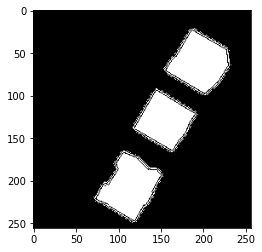

In [11]:
#To binarize the image, a simple thresholding for values above 0 is done. 
# Convert all values above 0 to 1, to assign a pixel value of 1 for the white class.

y_train = np.where(y_train>0, 1, y_train)
plt.imshow(y_train[0], cmap='gray')

In [12]:
# Expanding the dimension to get the appropriate formation for the model training

X_train = np.expand_dims(X_train, axis =3)
X_train = normalize(X_train, axis =1)                       # normalizing the data

X_test = np.expand_dims(X_test, axis =3)
X_test = normalize(X_test, axis =1)
y_train = np.expand_dims(y_train, axis =3)

X_val = np.expand_dims(X_val, axis =3)
X_val = normalize(X_val, axis =1)

y_val = np.expand_dims(y_val, axis =3)
X_train.shape


(22, 256, 256, 1)

###  Model (U-net)

The model below was inspired by [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/blob/master/228_semantic_segmentation_of_aerial_imagery_using_unet/simple_multi_unet_model.py) which has been customized according to the task at hand.

Since the segmentation in our case is within two classes black:0 and white:1, the sigmoid function has been used.


In [13]:
def unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(20, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
       
    return model

In [14]:
def getmodel():
    return unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

### Model training

In [22]:
model = getmodel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=10, epochs=20, 
                    callbacks=callbacks_list)
#import warnings
#warnings.filterwarnings("ignore")

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.6458
Epoch 00001: val_loss improved from inf to 59.30366, saving model to model.h5
3/3 [==============================] - 13s 3s/step - loss: 0.6301 - accuracy: 0.6458 - val_loss: 59.3037 - val_accuracy: 0.8452
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.7855
Epoch 00002: val_loss improved from 59.30366 to 39.71176, saving model to model.h5
3/3 [==============================] - 11s 3s/step - loss: 0.5267 - accuracy: 0.7855 - val_loss: 39.7118 - val_accuracy: 0.8423
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.8189
Epoch 00003: val_loss did not improve from 39.71176
3/3 [==============================] - 11s 3s/step - loss: 0.5002 - accuracy: 0.8189 - val_loss: 61.6229 - val_accuracy: 0.8459
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.8317
Epoch 00004: val_loss did not impro

### Results

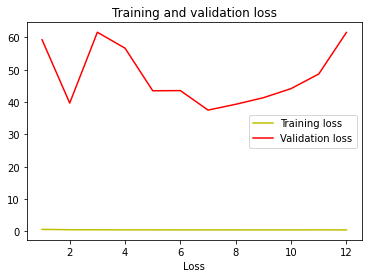

In [23]:
# plotting the training and validation accuracy, and loss at each epochs 

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xlabel("Loss")
plt.legend()
plt.show()

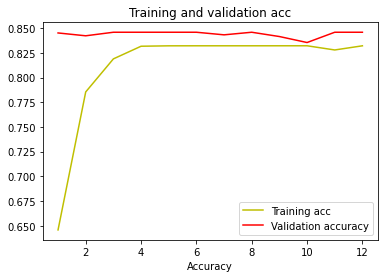

In [24]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title("Training and validation acc")
plt.xlabel("Epochs")
plt.xlabel("Accuracy")
plt.legend()
plt.show()

#### Evaluating the model

In [25]:
_,acc = model.evaluate(X_val, y_val)
print("Accuracy is =", (acc*100), "%")

1/1 [==============================] - 0s 307ms/step - loss: 61.5527 - accuracy: 0.8459
Accuracy is = 84.588623046875 %


#### Prediction

In [26]:


# use the best epoch
model.load_weights('model.h5')

prediction = model.predict(X_test)

prediction_thresh = (prediction >= .5).astype(np.uint8)
#len(prediction)

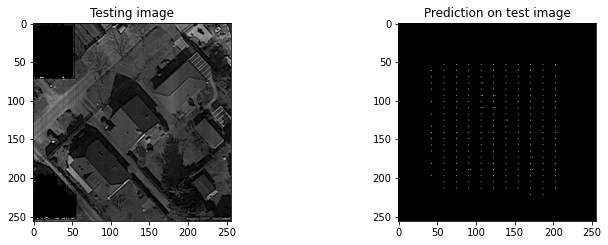

In [27]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
plt.figure(figsize=(12,8))
pred_img = prediction_thresh[test_img_number, :, :, 0]
plt.subplot(221)
plt.title('Testing image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Prediction on test image')
plt.imshow(pred_img, cmap='gray')

### Conclusion

This task was about training a neural network on 30 pictures of satellite houses with the corresponding label roofs of 25 of those. After training the model we were supposed to perform prediction on the five remaining satellite pictures. Based on the above analysis the following conclusion can drawn:

- Although we obtain a more than 80% accuracy, the validation loss is not stable, actually tends to be higher, which shows an overfitting. This overfitting could be due to the fact that the data set is small for the U-net model as it is. Therefore, despite the earlystopping criterion the model is too large for the given data set. Perhaps one can think of either creating it's own architecture or remove some layers without affecting (or much) the model's performance.
- Another aspect that would be great to investigate is do to the same analysis using the Intersection-over-Union (IoU) metric to understand how well the model performs.

- The fact that the given labels aren't really gray images (as they include pixel values between 0 and 255) could be as well be reason why the predicted images does not show up clearly. In fact the two classes (0:black and 255:white) are not clearly defined in the labels. After encoding the labels to 0 and 1, the label pictures appear blur, which could make it difficult for the model to train (therefore predict) properly.